Creating a new FrozenLake environment...
Initializing a new Q-learning agent...
Starting training for 50000 episodes...
Episode 500/50000, Success rate: 0.0900, Exploration rate: 0.0816
Episode 1000/50000, Success rate: 0.2500, Exploration rate: 0.0100
Episode 1500/50000, Success rate: 0.2200, Exploration rate: 0.0100
Episode 2000/50000, Success rate: 0.2400, Exploration rate: 0.0100
Episode 2500/50000, Success rate: 0.5300, Exploration rate: 0.0100
Episode 3000/50000, Success rate: 0.3500, Exploration rate: 0.0100
Episode 3500/50000, Success rate: 0.4700, Exploration rate: 0.0100
Episode 4000/50000, Success rate: 0.7600, Exploration rate: 0.0100
Episode 4500/50000, Success rate: 0.7800, Exploration rate: 0.0100
Episode 5000/50000, Success rate: 0.6900, Exploration rate: 0.0100
Episode 5500/50000, Success rate: 0.7500, Exploration rate: 0.0100
Episode 6000/50000, Success rate: 0.7200, Exploration rate: 0.0100
Episode 6500/50000, Success rate: 0.6900, Exploration rate: 0.0100
Episode 70

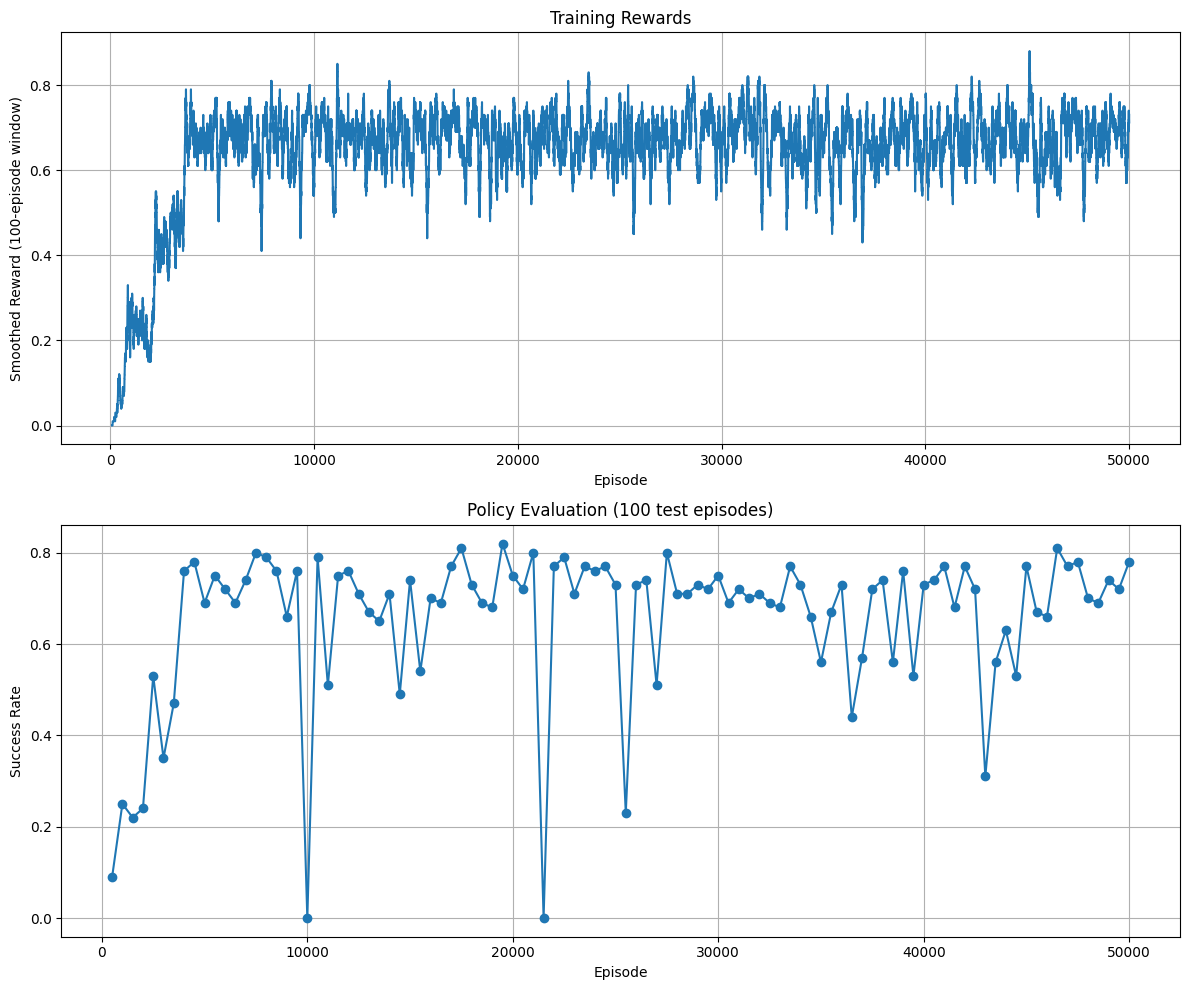

In [24]:
import os
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from q_learning_agent import QLearningAgent

def train_agent_with_plotting():
    """Train a Q-learning agent from scratch and plot its learning performance"""
    
    print("Creating a new FrozenLake environment...")
    env = gym.make('FrozenLake-v1', is_slippery=True)
    
    # Initialize a fresh agent
    print("Initializing a new Q-learning agent...")
    q_agent = QLearningAgent(env)
    
    # Training parameters
    num_episodes = 50000
    eval_interval = 500
    rewards = []
    success_rates = []
    
    print(f"Starting training for {num_episodes} episodes...")
    
    # Main training loop
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            # Choose an action using epsilon-greedy policy
            action = q_agent.choose_action(state)
            
            # Take step in environment with explicit boolean conversion
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = bool(terminated) or bool(truncated)
            
            # Update Q-table
            q_agent.update(state, action, reward, next_state, done)
            
            total_reward += reward
            state = next_state
        
        # Record reward
        rewards.append(total_reward)
        
        # Evaluate periodically
        if (episode + 1) % eval_interval == 0:
            # Evaluate current policy
            success_count = 0
            eval_episodes = 100
            
            for _ in range(eval_episodes):
                eval_state, _ = env.reset()
                eval_done = False
                
                while not eval_done:
                    # Use greedy policy for evaluation
                    eval_action = q_agent.get_optimal_action(eval_state)
                    eval_next_state, eval_reward, eval_terminated, eval_truncated, _ = env.step(eval_action)
                    eval_done = bool(eval_terminated) or bool(eval_truncated)
                    eval_state = eval_next_state
                    
                    # Check if reached goal
                    if eval_reward > 0:
                        success_count += 1
                        break
            
            success_rate = success_count / eval_episodes
            success_rates.append(success_rate)
            
            print(f"Episode {episode+1}/{num_episodes}, Success rate: {success_rate:.4f}, Exploration rate: {q_agent.exploration_rate:.4f}")
    
    # Save the trained Q-table
    q_agent.save("q_table_new.pkl")
    print("Training complete! Q-table saved to 'q_table_new.pkl'")
    
    # Plot the learning curves
    plot_learning_curves(rewards, success_rates, eval_interval)
    
    return q_agent

def plot_learning_curves(rewards, success_rates, eval_interval):
    """Create plots of the learning performance"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Smoothed rewards
    window_size = 100
    smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    
    ax1.plot(range(window_size-1, len(rewards)), smoothed_rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Smoothed Reward (100-episode window)')
    ax1.set_title('Training Rewards')
    ax1.grid(True)
    
    # Plot 2: Success rates
    episodes = [(i+1)*eval_interval for i in range(len(success_rates))]
    ax2.plot(episodes, success_rates, marker='o', linestyle='-')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.set_title('Policy Evaluation (100 test episodes)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('learning_performance.png')
    print("Learning curves saved to 'learning_performance.png'")

if __name__ == "__main__":
    # Train agent from scratch and plot learning curve
    agent = train_agent_with_plotting()
    
    # Final evaluation
    env = gym.make('FrozenLake-v1', is_slippery=True)
    success_count = 0
    final_eval_episodes = 1000
    
    print(f"Running final evaluation over {final_eval_episodes} episodes...")
    
    for i in range(final_eval_episodes):
        state, _ = env.reset()
        done = False
        
        while not done:
            action = agent.get_optimal_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = bool(terminated) or bool(truncated)
            state = next_state
            
            if reward > 0:
                success_count += 1
                break
    
    final_success_rate = success_count / final_eval_episodes
    print(f"Final Success Rate: {final_success_rate:.4f}")

In [23]:
import pickle
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from q_learning_agent import QLearningAgent
import csv

def collect_successful_q_values(q_agent, num_evaluation_episodes=10000, is_slippery=True):
    """
    Collect Q-values from all successful episodes during evaluation.
    
    Args:
        q_agent: Trained Q-learning agent
        num_evaluation_episodes: Number of episodes to evaluate
        is_slippery: Whether the frozen lake is slippery
        
    Returns:
        successful_episodes: List of successful episodes, each containing states and Q-values
    """
    env = gym.make('FrozenLake-v1', is_slippery=is_slippery)
    successful_episodes = []
    
    for _ in tqdm(range(num_evaluation_episodes), desc="Evaluating Episodes"):
        state, _ = env.reset()
        done = False
        episode_states = []
        episode_q_values = []
        
        while not done:
            # Record state and Q-values
            episode_states.append(state)
            episode_q_values.append(q_agent.get_q_values(state).copy())
            
            # Choose and take action
            action = q_agent.get_optimal_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            
            # Check if episode was successful
            if terminated and reward > 0:
                # Store this successful episode
                successful_episodes.append({
                    "states": episode_states,
                    "q_values": episode_q_values
                })
                break
    
    env.close()
    print(f"Collected {len(successful_episodes)} successful episodes out of {num_evaluation_episodes}")
    return successful_episodes

def create_batched_q_values(successful_episodes, batch_size=100):
    """
    Create batches of averaged Q-values from successful episodes.
    
    Args:
        successful_episodes: List of successful episodes
        batch_size: Number of episodes to average per batch
        
    Returns:
        batched_avg_q_values: List of dictionaries mapping states to average Q-values for each batch
    """
    batched_avg_q_values = []
    
    # Process episodes in batches
    num_batches = len(successful_episodes) // batch_size
    if num_batches == 0 and len(successful_episodes) > 0:
        num_batches = 1  # At least one batch if we have successful episodes
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(successful_episodes))
        
        batch_episodes = successful_episodes[start_idx:end_idx]
        
        # Collect all Q-values by state for this batch
        state_q_values = {}
        for episode in batch_episodes:
            for s, q_vals in zip(episode["states"], episode["q_values"]):
                if s not in state_q_values:
                    state_q_values[s] = []
                state_q_values[s].append(q_vals)
        
        # Average Q-values for each state in this batch
        avg_q_values = {}
        for state, q_values_list in state_q_values.items():
            avg_q_values[state] = np.mean(q_values_list, axis=0)
        
        batched_avg_q_values.append(avg_q_values)
        print(f"Created batch {batch_idx+1}/{num_batches} with {len(batch_episodes)} episodes")
    
    return batched_avg_q_values

def generate_expert_demonstrations_with_batched_q_values(q_agent, batched_avg_q_values, 
                                                         demos_per_batch=100, is_slippery=True):
    """
    Generate expert demonstrations using a trained Q-learning agent and batched average Q-values.
    
    Args:
        q_agent: Trained Q-learning agent
        batched_avg_q_values: List of dictionaries mapping states to average Q-values for each batch
        demos_per_batch: Number of demonstrations to generate per batch
        is_slippery: Whether the frozen lake is slippery
        
    Returns:
        all_demos: List of demonstration dictionaries
    """
    env = gym.make('FrozenLake-v1', is_slippery=is_slippery, render_mode="ansi")
    all_demos = []
    
    # Action mapping
    action_map = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}
    
    # Generate demonstrations for each batch
    for batch_idx, avg_q_values in enumerate(batched_avg_q_values):
        batch_demos = []
        
        for _ in tqdm(range(demos_per_batch), 
                     desc=f"Generating Demos for Batch {batch_idx+1}/{len(batched_avg_q_values)}"):
            state, _ = env.reset()
            done = False
            
            while not done:
                # Get state representation
                state_str = env.render()
                
                # Get expert action from Q-table
                action = q_agent.get_optimal_action(state)
                action_text = action_map[action]
                
                # Get Q-values from the averaged batch
                if state in avg_q_values:
                    q_values = avg_q_values[state]
                else:
                    # Fallback to agent's Q-values if state not in the averaged batch
                    q_values = q_agent.get_q_values(state)
                
                # Take action in environment
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                # Create demo example
                demo = {
                    "state": state,
                    "state_str": state_str,
                    "action": action,
                    "action_text": action_text,
                    "q_values": q_values.tolist(),
                    "reward": reward,
                    "next_state": next_state,
                    "done": done,
                    "batch_idx": batch_idx  # Track which batch this demo came from
                }
                
                batch_demos.append(demo)
                state = next_state
                
                if done:
                    break
        
        all_demos.extend(batch_demos)
    
    env.close()
    return all_demos

if __name__ == "__main__":
    # Load a trained expert agent
    env = gym.make('FrozenLake-v1', is_slippery=True)
    q_agent = QLearningAgent(env)
    
    # Try to load the saved expert Q-table
    try:
        q_agent.load("q_table_new.pkl")
        print("Loaded expert Q-table.")
        
        # Verify it's an expert
        success_rate = q_agent.evaluate(num_episodes=100)
        print(f"Expert agent success rate: {success_rate:.2f}")
        
        if success_rate < 0.7:
            print("WARNING: Loaded agent does not meet expertise threshold!")
            print("Run train_expert_agent.py first to generate an expert agent.")
            exit(1)
            
    except FileNotFoundError:
        print("No expert Q-table found. Run train_expert_agent.py first.")
        exit(1)
    
    # Steps 1-3 remain the same
    print("Collecting Q-values from successful episodes...")
    successful_episodes = collect_successful_q_values(q_agent, num_evaluation_episodes=10000)
    
    print("Creating batched average Q-values...")
    batched_avg_q_values = create_batched_q_values(successful_episodes, batch_size=100)
    
    print("Generating expert demonstrations with batched average Q-values...")
    all_demos = generate_expert_demonstrations_with_batched_q_values(
        q_agent, batched_avg_q_values, demos_per_batch=100)
    
    # Save demonstrations to CSV
    csv_filename = "expert_demos_batched_avg_q.csv"
    fieldnames = [
        'state', 'state_str', 'action', 'action_text',
        'q_value_left', 'q_value_down', 'q_value_right', 'q_value_up',
        'reward', 'next_state', 'done', 'batch_idx'
    ]
    
    print(f"Saving demonstrations to {csv_filename}...")
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for demo in all_demos:
            # Create a flattened version of the demo dictionary
            flat_demo = {
                'state': demo['state'],
                'state_str': demo['state_str'].replace('\n', '|'),  # Replace newlines with pipe for CSV
                'action': demo['action'],
                'action_text': demo['action_text'],
                'q_value_left': demo['q_values'][0],
                'q_value_down': demo['q_values'][1],
                'q_value_right': demo['q_values'][2],
                'q_value_up': demo['q_values'][3],
                'reward': demo['reward'],
                'next_state': demo['next_state'],
                'done': demo['done'],
                'batch_idx': demo['batch_idx']
            }
            writer.writerow(flat_demo)
    
    print(f"Generated and saved {len(all_demos)} expert demonstrations to CSV")

Loaded expert Q-table.
Expert agent success rate: 0.69
Run train_expert_agent.py first to generate an expert agent.


Evaluating Episodes: 100%|██████████| 10000/10000 [00:06<00:00, 1497.67it/s]


Collected 7358 successful episodes out of 10000
Creating batched average Q-values...
Created batch 1/73 with 100 episodes
Created batch 2/73 with 100 episodes
Created batch 3/73 with 100 episodes
Created batch 4/73 with 100 episodes
Created batch 5/73 with 100 episodes
Created batch 6/73 with 100 episodes
Created batch 7/73 with 100 episodes
Created batch 8/73 with 100 episodes
Created batch 9/73 with 100 episodes
Created batch 10/73 with 100 episodes
Created batch 11/73 with 100 episodes
Created batch 12/73 with 100 episodes
Created batch 13/73 with 100 episodes
Created batch 14/73 with 100 episodes
Created batch 15/73 with 100 episodes
Created batch 16/73 with 100 episodes
Created batch 17/73 with 100 episodes
Created batch 18/73 with 100 episodes
Created batch 19/73 with 100 episodes
Created batch 20/73 with 100 episodes
Created batch 21/73 with 100 episodes
Created batch 22/73 with 100 episodes
Created batch 23/73 with 100 episodes
Created batch 24/73 with 100 episodes
Created batc

Generating Demos for Batch 73/73: 100%|██████████| 100/100 [00:00<00:00, 1108.31it/s]


Saving demonstrations to expert_demos_batched_avg_q.csv...
Generated and saved 302416 expert demonstrations to CSV


In [3]:
import os
import random
import re
import numpy as np
import pandas as pd
from typing import Dict, List, Any, Optional, Union, Tuple

class XMLParser:
    """Parser for extracting content from XML tags."""
    
    def __init__(self, fields=None):
        self.fields = fields or []
    
    def parse(self, text):
        result = type('obj', (object,), {field: None for field in self.fields})
        
        for field in self.fields:
            pattern = f"<{field}>(.*?)</{field}>"
            match = re.search(pattern, text, re.DOTALL)
            if match:
                setattr(result, field, match.group(1).strip())
        
        return result

def prepare_dataset_for_deepseek(demos_df, system_prompt=None, few_shot=None):
    """Prepare the dataset for DeepSeek training."""
    examples = []
    
    for _, row in demos_df.iterrows():
        try:
            # Format the prompt
            prompt_data = format_prompt(
                row["state_str"], 
                system_prompt=system_prompt, 
                few_shot=few_shot
            )
            
            example = {
                "prompt": prompt_data,
                "action": row["action"],
                "action_text": row["action_text"],
                "state": row["state"],
                "q_values": [
                    row["q_value_left"],
                    row["q_value_down"],
                    row["q_value_right"],
                    row["q_value_up"]
                ],
            }
            
            examples.append(example)
        except Exception as e:
            print(f"Error processing demo: {e}")
            continue
    
    return pd.DataFrame(examples)

def format_prompt(state_str, system_prompt=None, few_shot=None):
    """Format the prompt for the model."""
    messages = []
    
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    
    if few_shot:
        messages.extend(few_shot)
    
    user_content = f"""Current Frozen Lake state:
{state_str}

What action should I take to maximize my chances of reaching the goal safely? 
Respond with one of: LEFT, DOWN, RIGHT, UP.

First think through your reasoning in <think> tags, then provide your final answer in <answer> tags.
"""
    messages.append({"role": "user", "content": user_content})
    
    return messages

class FrozenLakeEnv:
    """Environment for the Frozen Lake problem using verifiers framework."""
    
    def __init__(
        self,
        system_prompt="You are an expert at solving the Frozen Lake environment.",
        few_shot=None,
        max_steps=1,
    ):
        self.system_prompt = system_prompt
        self.few_shot = few_shot
        self.max_steps = max_steps
        self.parser = XMLParser(fields=["think", "answer"])
    
    def get_dataset(self):
        """Get the dataset for training."""
        # Load the expert demonstrations from CSV
        demos_df = pd.read_csv("expert_demos_batched_avg_q.csv")
        
        # Convert pipe separators back to newlines in state_str
        demos_df['state_str'] = demos_df['state_str'].str.replace('|', '\n')
        
        # Prepare dataset for DeepSeek
        dataset = prepare_dataset_for_deepseek(
            demos_df, 
            system_prompt=self.system_prompt,
            few_shot=self.few_shot
        )
        
        return dataset
    
    def get_eval_dataset(self, n=100):
        """Get evaluation dataset."""
        full_dataset = self.get_dataset()
        
        if len(full_dataset) > n:
            return full_dataset.sample(n=n)
        return full_dataset
    
    def generate(self, prompts, llm, sampling_params):
        """Generate completions using the LLM."""
        completions = llm.generate(prompts, sampling_params)
        
        ids = []
        messages = []
        masks = []
        
        for completion in completions:
            ids.append(completion.outputs[0].token_ids)
            messages.append(completion.outputs[0].text)
            mask = [1] * len(completion.outputs[0].token_ids)
            masks.append(mask)
        
        return {
            'ids': ids,
            'messages': messages,
            'mask': masks
        }
    
    def get_rubric(self, **kwargs):
        """Get the reward functions for evaluation."""
        
        def correctness_reward_func(prompts, completions, **kwargs):
            """Reward function based on Q-values."""
            q_values_list = kwargs.get("q_values", [])
            expert_actions = kwargs.get("action", [])
            
            rewards = []
            for completion, q_values, expert_action in zip(completions, q_values_list, expert_actions):
                parsed = self.parser.parse(completion)
                if parsed.answer is None:
                    rewards.append(0.0)
                    continue
                
                action_map = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}
                pred_action = action_map.get(parsed.answer.strip().upper(), -1)
                
                if pred_action == -1:
                    rewards.append(0.0)
                    continue
                
                expert_q_value = q_values[expert_action]
                pred_q_value = q_values[pred_action]
                
                q_max = max(q_values)
                q_min = min(q_values)
                
                if q_max > q_min:
                    normalized_pred_q = (pred_q_value - q_min) / (q_max - q_min)
                    exact_match_bonus = 0.2 if pred_action == expert_action else 0.0
                    reward = normalized_pred_q + exact_match_bonus
                    rewards.append(min(1.0, reward))
                else:
                    reward = 1.0 if pred_action == expert_action else 0.5
                    rewards.append(reward)
            
            return rewards
        
        def format_reward_func(prompts, completions, **kwargs):
            """Reward function for proper XML formatting."""
            rewards = []
            
            for completion in completions:
                think_tag = re.search(r"<think>(.*?)</think>", completion, re.DOTALL)
                answer_tag = re.search(r"<answer>(.*?)</answer>", completion, re.DOTALL)
                
                if think_tag and answer_tag:
                    rewards.append(1.0)
                elif answer_tag:
                    rewards.append(0.5)
                else:
                    rewards.append(0.0)
            
            return rewards
        
        return [correctness_reward_func, format_reward_func]

def train_deepseek_on_frozen_lake():
    """Train DeepSeek on Frozen Lake using Q-learning demonstrations."""
    try:
        import torch
        import verifiers as vf
        from verifiers.trainers.grpo_env_trainer import GRPOEnvTrainer
    except ImportError as e:
        print(f"Error importing torch or verifiers: {e}")
        print("This functionality requires PyTorch and the verifiers package.")
        return
    
    # Initialize environment
    fl_env = FrozenLakeEnv()
    
    # Get dataset and rubric
    dataset = fl_env.get_dataset()
    eval_dataset = fl_env.get_eval_dataset(n=100)
    rubric = fl_env.get_rubric()
    
    # Load model and tokenizer
    model, tokenizer = vf.get_model_and_tokenizer("deepseek-ai/deepseek-llm-7b-base")
    
    # Training arguments
    run_name = "frozen-lake-deepseek-qlearning"
    training_args = vf.get_default_grpo_config(
        run_name=run_name,
        num_gpus=1
    )
    
    # Configure training parameters
    training_args.num_generations = 7  # Rollouts per prompt
    training_args.per_device_train_batch_size = 6  # Minibatch size per GPU
    training_args.gradient_accumulation_steps = 4  # Batches to accumulate
    training_args.num_iterations = 2  # Steps per global batch
    training_args.beta = 0.04  # KL penalty
    training_args.use_vllm = True  # Enable vLLM
    
    # Initialize trainer
    trainer = GRPOEnvTrainer(
        model=model,
        processing_class=tokenizer,
        reward_funcs=rubric,
        env=fl_env,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=eval_dataset,
    )
    
    # Start training
    trainer.train()
    
    # Save the final model
    trainer.save_model("frozen-lake-deepseek-final")

if __name__ == "__main__":
    train_deepseek_on_frozen_lake()


Error importing torch or verifiers: No module named 'verifiers.trainers'
This functionality requires PyTorch and the verifiers package.


In [1]:
import os
import random
import re
import numpy as np
import pandas as pd
from typing import Dict, List, Any, Optional, Union, Tuple
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainerCallback
from trl import GRPOTrainer, GRPOConfig
from datasets import Dataset
from peft import LoraConfig, get_peft_model

# Set PyTorch memory allocation configuration
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Set Hugging Face cache directory to /scratch/athanina
os.environ["HF_HOME"] = "/scratch/athanina/huggingface_cache"
os.makedirs(os.environ["HF_HOME"], exist_ok=True)

# --- XML Parser ---
class XMLParser:
    """Parser for extracting content from XML tags."""
    def __init__(self, fields=None):
        self.fields = fields or []
    
    def parse(self, text):
        """Parse text to extract content within specified XML tags."""
        result = type('obj', (object,), {field: None for field in self.fields})
        for field in self.fields:
            pattern = f"<{field}>(.*?)</{field}>"
            match = re.search(pattern, text, re.DOTALL)
            if match:
                setattr(result, field, match.group(1).strip())
        return result

# --- Prompt Formatting ---
def format_prompt(state_str, system_prompt=None, few_shot=None):
    """Format the prompt for the Frozen Lake task with few-shot examples."""
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    if few_shot:
        messages.extend(few_shot)
    
    user_content = f"""Current Frozen Lake state:
{state_str}

What action should I take to maximize my chances of reaching the goal safely? 
Respond with one of: LEFT, DOWN, RIGHT, UP.

First think through your reasoning in <think> tags, then provide your final answer in <answer> tags.
"""
    messages.append({"role": "user", "content": user_content})
    return "\n".join([f"{msg['role']}: {msg['content']}" for msg in messages])

# --- Frozen Lake Environment ---
class FrozenLakeEnv:
    def __init__(
        self,
        system_prompt="You are an expert at solving the Frozen Lake environment.",
        max_steps=1,
    ):
        """Initialize the Frozen Lake environment for RL training."""
        self.system_prompt = system_prompt
        self.max_steps = max_steps
        self.parser = XMLParser(fields=["think", "answer"])
        self.few_shot = [
            {
                "role": "user",
                "content": """Current Frozen Lake state:
S F F F
F H F H
F F F H
H F F G

What action should I take to maximize my chances of reaching the goal safely? 
Respond with one of: LEFT, DOWN, RIGHT, UP."""
            },
            {
                "role": "assistant",
                "content": """<think>The goal (G) is at the bottom-right (3,3). From the start (S) at (0,0), moving RIGHT to (0,1) 'F' keeps me on safe ice and progresses toward the goal.</think>
<answer>RIGHT</answer>"""
            },
            {
                "role": "user",
                "content": """Current Frozen Lake state:
F F S F
F H F H
F F F H
H F F G

What action should I take to maximize my chances of reaching the goal safely? 
Respond with one of: LEFT, DOWN, RIGHT, UP."""
            },
            {
                "role": "assistant",
                "content": """<think>I'm at (0,2), and the goal is at (3,3). Moving DOWN to (1,2) 'F' is safe and brings me closer to the goal vertically.</think>
<answer>DOWN</answer>"""
            },
            {
                "role": "user",
                "content": """Current Frozen Lake state:
F S F F
F H F H
F F F H
H F F G

What action should I take to maximize my chances of reaching the goal safely? 
Respond with one of: LEFT, DOWN, RIGHT, UP."""
            }
            
            
        ]
        self.dataset = self._load_dataset()

    def _load_dataset(self):
        """Load and validate expert demonstrations from CSV."""
        try:
            demos_df = pd.read_csv("expert_demos_batched_avg_q.csv")
            required_cols = ["state_str", "action", "q_value_left", "q_value_down", "q_value_right", "q_value_up"]
            if not all(col in demos_df.columns for col in required_cols):
                raise ValueError(f"CSV missing required columns: {set(required_cols) - set(demos_df.columns)}")
            demos_df = demos_df.dropna(subset=required_cols[1:])
            demos_df['state_str'] = demos_df['state_str'].str.replace('|', '\n')
        except Exception as e:
            raise RuntimeError(f"Failed to load dataset: {e}")

        examples = []
        for _, row in demos_df.iterrows():
            prompt = format_prompt(
                row["state_str"],
                system_prompt=self.system_prompt,
                few_shot=self.few_shot
            )
            examples.append({
                "prompt": prompt,
                "action": row["action"],
                "q_values": [
                    row["q_value_left"],
                    row["q_value_down"],
                    row["q_value_right"],
                    row["q_value_up"]
                ]
            })
        return pd.DataFrame(examples)

    def get_dataset(self, n=None):
        """Return a subset or full dataset."""
        if n and len(self.dataset) > n:
            return self.dataset.sample(n=n)
        return self.dataset

    def evaluate_action(self, completion, q_values, expert_action):
        """Calculate reward based on Q-values and formatting."""
        parsed = self.parser.parse(completion)
        think_tag = bool(re.search(r"<think>(.*?)</think>", completion, re.DOTALL))
        answer_tag = bool(re.search(r"<answer>(.*?)</answer>", completion, re.DOTALL))
        format_reward = 1.0 if (think_tag and answer_tag) else 0.0
        
        if parsed.answer is None:
            correctness_reward = 0.0
        else:
            action_map = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}
            pred_action = action_map.get(parsed.answer.strip().upper(), -1)
            if pred_action == -1:
                correctness_reward = 0.0
            else:
                expert_q_value = q_values[expert_action]
                pred_q_value = q_values[pred_action]
                q_max, q_min = max(q_values), min(q_values)
                if q_max > q_min:
                    normalized_pred_q = (pred_q_value - q_min) / (q_max - q_min)
                    exact_match_bonus = 0.2 if pred_action == expert_action else 0.0
                    correctness_reward = min(1.0, normalized_pred_q + exact_match_bonus)
                else:
                    correctness_reward = 1.0 if pred_action == expert_action else 0.5
        
        return (format_reward + correctness_reward) / 2

    def get_rubric(self):
        """Return the primary reward function for GRPO training."""
        def combined_reward_func(prompts, completions, **kwargs):
            q_values_list = kwargs["q_values"]
            expert_actions = kwargs["action"]
            rewards = []
            for i, (completion, q_values, expert_action) in enumerate(zip(completions, q_values_list, expert_actions)):
                # Use the existing evaluate_action which combines format and correctness
                reward = self.evaluate_action(completion, q_values, expert_action) 
                if reward == 0.0 and self.parser.parse(completion).answer is None:
                     # Keep the warning for debugging
                    print(f"Warning: Low reward (likely format/parse issue) in completion {i}: {completion}")
                rewards.append(reward)
            return rewards
        
        # Return only the single combined reward function
        return [combined_reward_func]

# --- Custom Logging Callback ---
class LoggingCallback(TrainerCallback):
    """Callback to log training progress for research analysis."""
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            print(f"Step {state.global_step}: {logs}")
    
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 10 == 0:
            print(f"Step {state.global_step} - Sample completion: {kwargs.get('outputs', 'No outputs yet')}")

# --- Training Function ---
def train_deepseek_on_frozen_lake_with_grpo():
    """Train DeepSeek on Frozen Lake using GRPO with expert Q-value demonstrations on an A100."""
    env = FrozenLakeEnv()
    # Reduce dataset size to manage memory usage
    train_dataset = env.get_dataset(n=500)
    eval_dataset = env.get_dataset(n=100)
    reward_funcs = env.get_rubric()

    # Load DeepSeek model and tokenizer
    model_name = "google/gemma-2b-it"
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        padding_side="left",
        truncation=True,
        max_length=1024
    )
    
    # Load model with automatic device map for memory optimization
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,  # Changed from bfloat16 to float16
        device_map="auto"  # Use auto device mapping for memory optimization
    )
    
    # Configure LoRA for parameter-efficient fine-tuning
    lora_config = LoraConfig(
        r=16,  # Reduced from typical 16 to save memory
        lora_alpha=16,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    model = get_peft_model(model, lora_config)
    
    # Verify which parameters will be trained
    print("Checking trainable parameters:")
    trainable_params = 0
    all_params = 0
    for name, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            print(f"{name}: requires_grad=True, shape={param.shape}, dtype={param.dtype}")
    
    print(f"Trainable params: {trainable_params} ({100 * trainable_params / all_params:.2f}% of all params)")

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    train_dataset = Dataset.from_pandas(train_dataset)
    eval_dataset = Dataset.from_pandas(eval_dataset)

    # GRPO configuration with memory optimizations
    grpo_config = GRPOConfig(
        output_dir="./gemma-2b-it",
        num_train_epochs=10,
        per_device_train_batch_size=2,  # Reduced from 8
        per_device_eval_batch_size=2,   # Reduced from 8
        gradient_accumulation_steps=8,  # Increased from 2
        learning_rate=3e-5,
        weight_decay=0.01,
        logging_steps=5,
        save_steps=100,  # Increased to reduce disk I/O
        eval_strategy="steps",
        eval_steps=50,   # Increased to reduce evaluation frequency
        fp16=True,       # Use FP16 precision
        bf16=False,      # Ensure BF16 is disabled
        report_to="none",
        num_generations=4,  # Reduced from 4
        beta=0.1,
        gradient_checkpointing=True,
        optim="adamw_torch",  # Specify optimizer explicitly
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        max_grad_norm=1.0,
        # Additional memory optimizations
        deepspeed=None,  # Disable DeepSpeed if not needed
        ddp_find_unused_parameters=False,
    )

    # Initialize GRPO trainer
    trainer = GRPOTrainer(
        model=model,
        args=grpo_config,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=tokenizer,
        reward_funcs=reward_funcs,
        callbacks=[LoggingCallback()]
    )

    print("Starting training on NVIDIA A100...")
    try:
        trainer.train()
        success = True
    except Exception as e:
        print(f"Training error: {e}")
        success = False
    
    if success:
        trainer.save_model("./frozen-lake-gemma-2b-it-final")
        tokenizer.save_pretrained("./frozen-lake-gemma-2b-it-final")
        print("Training completed. Model saved to './frozen-lake-gemma-2b-it-final'.")
    else:
        # Try to save checkpoint even if training fails
        try:
            trainer.save_model("./frozen-lake-gemma-2b-it-checkpoint")
            tokenizer.save_pretrained("./frozen-lake-gemma-2b-it-checkpoint")
            print("Training failed but checkpoint saved to './frozen-lake-gemma-2b-it-checkpoint'.")
        except:
            print("Could not save checkpoint.")

if __name__ == "__main__":
    train_deepseek_on_frozen_lake_with_grpo()

KeyboardInterrupt: 

In [27]:
import os
import random
import re
import numpy as np
import pandas as pd
from typing import Dict, List, Any, Optional, Union, Tuple
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainerCallback
from trl import GRPOTrainer, GRPOConfig
from datasets import Dataset
from peft import LoraConfig, get_peft_model

# Set PyTorch memory allocation configuration
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Set Hugging Face cache directory to /scratch/athanina
os.environ["HF_HOME"] = "/scratch/athanina/huggingface_cache"
os.makedirs(os.environ["HF_HOME"], exist_ok=True)

# --- XML Parser ---
class XMLParser:
    """Parser for extracting content from XML tags."""
    def __init__(self, fields=None):
        self.fields = fields or []

    def parse(self, text):
        """Parse text to extract content within specified XML tags."""
        result = type('obj', (object,), {field: None for field in self.fields})() # Create instance
        for field in self.fields:
            pattern = f"<{field}>(.*?)</{field}>"
            match = re.search(pattern, text, re.DOTALL)
            if match:
                setattr(result, field, match.group(1).strip())
        return result

# --- Prompt Formatting ---
def format_prompt(state_str, system_prompt=None, few_shot=None):
    """Format the prompt for the Frozen Lake task with few-shot examples."""
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    if few_shot:
        messages.extend(few_shot)

    user_content = f"""Current Frozen Lake state:
{state_str}

What action should I take to maximize my chances of reaching the goal safely?
Respond with one of: LEFT, DOWN, RIGHT, UP.

First think through your reasoning in <think> tags, then provide your final answer in <answer> tags.
"""
    messages.append({"role": "user", "content": user_content})
    # Gemma instruction format uses specific tokens
    # Format: "<start_of_turn>user\n{user_content}<end_of_turn>\n<start_of_turn>model\n"
    prompt_str = "<start_of_turn>user\n"
    if system_prompt:
         prompt_str += system_prompt + "\n\n" # Add system prompt if present
    if few_shot:
        for i in range(0, len(few_shot), 2):
            prompt_str += few_shot[i]['content'] # User part
            prompt_str += "<end_of_turn>\n<start_of_turn>model\n"
            prompt_str += few_shot[i+1]['content'] # Assistant part
            prompt_str += "<end_of_turn>\n<start_of_turn>user\n" # Prepare for next user turn

    prompt_str += user_content # Add the final user query
    prompt_str += "<end_of_turn>\n<start_of_turn>model\n" # Signal model to respond

    # Note: The above formatting assumes the tokenizer adds BOS/EOS appropriately.
    # Depending on the specific Gemma tokenizer usage, slight adjustments might be needed.
    # Let's simplify for now and assume the tokenizer handles the structure.
    # Reverting to simpler format for clarity, check Gemma docs if issues arise.
    messages_formatted = []
    if system_prompt:
         messages_formatted.append(f"System: {system_prompt}")
    if few_shot:
        for msg in few_shot:
            messages_formatted.append(f"{msg['role']}: {msg['content']}")
    messages_formatted.append(f"user: {user_content}")
    messages_formatted.append("model:") # Prompt model to start generating

    # Using a simple join for now, ensure tokenizer handles roles if needed
    return "\n".join(messages_formatted)


# --- Frozen Lake Environment ---
class FrozenLakeEnv:
    def __init__(
        self,
        system_prompt="You are an expert at solving the Frozen Lake environment. Analyze the state and provide your reasoning before giving the action.",
        max_steps=1, # Unused currently
    ):
        """Initialize the Frozen Lake environment for RL training."""
        self.system_prompt = system_prompt
        self.max_steps = max_steps
        self.parser = XMLParser(fields=["think", "answer"])
        # Reduced few-shot examples
        self.few_shot = [
             {
                "role": "user",
                "content": """Current Frozen Lake state:
S F F F
F H F H
F F F H
H F F G

What action should I take to maximize my chances of reaching the goal safely?
Respond with one of: LEFT, DOWN, RIGHT, UP.

First think through your reasoning in <think> tags, then provide your final answer in <answer> tags."""
            },
            {
                "role": "assistant",
                "content": """<think>The goal (G) is at the bottom-right (3,3). From the start (S) at (0,0), moving RIGHT to (0,1) 'F' keeps me on safe ice and progresses toward the goal.</think>
<answer>RIGHT</answer>"""
            },
            {
                "role": "user",
                "content": """Current Frozen Lake state:
F F S F
F H F H
F F F H
H F F G

What action should I take to maximize my chances of reaching the goal safely?
Respond with one of: LEFT, DOWN, RIGHT, UP.

First think through your reasoning in <think> tags, then provide your final answer in <answer> tags."""
            },
            {
                "role": "assistant",
                "content": """<think>I'm at (0,2), and the goal is at (3,3). Moving DOWN to (1,2) 'F' is safe and brings me closer to the goal vertically.</think>
<answer>DOWN</answer>"""
            },
             { # Adding one more distinct example
                "role": "user",
                "content": """Current Frozen Lake state:
F F F F
F H F H
F F S H
H F F G

What action should I take to maximize my chances of reaching the goal safely?
Respond with one of: LEFT, DOWN, RIGHT, UP.

First think through your reasoning in <think> tags, then provide your final answer in <answer> tags."""
            },
            {
                "role": "assistant",
                "content": """<think>I'm at (2,2), and the goal is at (3,3). Moving DOWN to (3,2) 'F' is safe, then I can move RIGHT to (3,3) 'G' to reach the goal.</think>
<answer>DOWN</answer>"""
            }
        ]
        self.dataset = self._load_dataset()
        self.action_map = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}
        self.reverse_action_map = {v: k for k, v in self.action_map.items()}


    def _load_dataset(self):
        """Load and validate expert demonstrations from CSV."""
        try:
            demos_df = pd.read_csv("expert_demos_batched_avg_q.csv")
            required_cols = ["state_str", "action", "q_value_left", "q_value_down", "q_value_right", "q_value_up"]
            if not all(col in demos_df.columns for col in required_cols):
                raise ValueError(f"CSV missing required columns: {set(required_cols) - set(demos_df.columns)}")
            demos_df = demos_df.dropna(subset=required_cols[1:]) # Drop rows with missing Q-values or action
             # Ensure action is integer if it's not already
            if demos_df['action'].dtype != np.int64 and demos_df['action'].dtype != np.int32:
                 # Assuming action might be stored as string name, map it
                 action_map_load = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}
                 # Handle potential errors during mapping
                 demos_df['action'] = demos_df['action'].apply(lambda x: action_map_load.get(str(x).upper(), -1))
                 demos_df = demos_df[demos_df['action'] != -1] # Remove rows with invalid actions
            demos_df['state_str'] = demos_df['state_str'].str.replace('|', '\n', regex=False)

        except FileNotFoundError:
             raise RuntimeError("Failed to load dataset: expert_demos_batched_avg_q.csv not found.")
        except Exception as e:
            raise RuntimeError(f"Failed to load or process dataset: {e}")

        examples = []
        for _, row in demos_df.iterrows():
            prompt = format_prompt(
                row["state_str"],
                system_prompt=self.system_prompt,
                few_shot=self.few_shot
            )
            # Ensure Q-values are floats
            q_values = [
                float(row["q_value_left"]),
                float(row["q_value_down"]),
                float(row["q_value_right"]),
                float(row["q_value_up"])
            ]
            examples.append({
                "prompt": prompt,
                "action": int(row["action"]), # Ensure action is integer index
                "q_values": q_values
            })
        return pd.DataFrame(examples)

    def get_dataset(self, n=None):
        """Return a subset or full dataset."""
        if n and len(self.dataset) > n:
            # Use random_state for reproducibility if needed
            return self.dataset.sample(n=n, random_state=42)
        return self.dataset

    def evaluate_action(self, completion, q_values, expert_action_index):
        """Calculate reward based on Q-values and formatting."""
        parsed = self.parser.parse(completion)
        think_tag = bool(re.search(r"<think>(.*?)</think>", completion, re.DOTALL))
        answer_tag = bool(re.search(r"<answer>(.*?)</answer>", completion, re.DOTALL))
        format_reward = 1.0 if (think_tag and answer_tag) else 0.0

        correctness_reward = 0.0 # Default to 0
        if parsed.answer is not None:
            pred_action_str = parsed.answer.strip().upper()
            pred_action_index = self.action_map.get(pred_action_str, -1)

            if pred_action_index != -1:
                # Ensure Q-values are valid numbers
                if not all(isinstance(q, (int, float)) for q in q_values):
                     print(f"Warning: Invalid Q-values encountered: {q_values}")
                     # Handle invalid Q-values, e.g., return minimal reward or skip
                     return format_reward * 0.1 # Penalize heavily but keep format signal

                expert_q_value = q_values[expert_action_index]
                pred_q_value = q_values[pred_action_index]
                q_max, q_min = max(q_values), min(q_values)

                if q_max > q_min:
                    # Normalize predicted Q-value
                    normalized_pred_q = (pred_q_value - q_min) / (q_max - q_min)
                    # Add bonus for exact match with expert action index
                    exact_match_bonus = 0.2 if pred_action_index == expert_action_index else 0.0
                    # Combine normalized Q + bonus, capped at 1.0
                    correctness_reward = min(1.0, normalized_pred_q + exact_match_bonus)
                else:
                    # Handle case where all Q-values are the same
                    correctness_reward = 1.0 if pred_action_index == expert_action_index else 0.5
            # else: pred_action_index == -1 (invalid action string), correctness_reward remains 0.0

        # Combine format and correctness rewards (equal weighting)
        final_reward = (format_reward + correctness_reward) / 2.0
        return final_reward


    # Updated rubric as suggested
    def get_rubric(self):
        """Return the primary reward function for GRPO training."""
        def combined_reward_func(prompts: List[str], completions: List[str], **kwargs) -> List[float]:
            # Ensure necessary kwargs are present
            if "q_values" not in kwargs or "action" not in kwargs:
                 raise ValueError("Missing 'q_values' or 'action' in reward function kwargs")

            q_values_list = kwargs["q_values"]
            expert_actions_indices = kwargs["action"] # Assuming 'action' is the expert index
            rewards = []

            if not (len(completions) == len(q_values_list) == len(expert_actions_indices)):
                 print(f"Warning: Mismatch in lengths - completions: {len(completions)}, q_values: {len(q_values_list)}, actions: {len(expert_actions_indices)}")
                 # Handle mismatch, e.g., return default rewards or skip batch
                 return [0.0] * len(completions) # Example: return 0 reward for all

            for i, (completion, q_values, expert_action_index) in enumerate(zip(completions, q_values_list, expert_actions_indices)):
                # Ensure expert_action_index is valid
                if not isinstance(expert_action_index, int) or not (0 <= expert_action_index < 4):
                     print(f"Warning: Invalid expert action index {expert_action_index} at index {i}. Skipping reward calculation.")
                     rewards.append(0.0) # Assign zero reward for invalid data
                     continue

                # Ensure q_values is a list of numbers
                if not isinstance(q_values, list) or len(q_values) != 4:
                     print(f"Warning: Invalid q_values format {q_values} at index {i}. Skipping reward calculation.")
                     rewards.append(0.0)
                     continue

                reward = self.evaluate_action(completion, q_values, expert_action_index)
                # Optional: Add more verbose logging for debugging low rewards
                # if reward < 0.1:
                #    print(f"Debug: Low reward ({reward:.2f}) for completion {i}: {completion[:100]}... | Expert Action Index: {expert_action_index} | Q-values: {q_values}")
                rewards.append(reward)
            return rewards

        # Return only the single combined reward function in a list
        return [combined_reward_func]


# --- Custom Logging Callback ---
class LoggingCallback(TrainerCallback):
    """Callback to log training progress and sample completions."""
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            # Basic console logging of metrics reported by Trainer
            print(f"Step {state.global_step}: {logs}")

    # Optional: Log sample completions periodically (can be verbose)
    # def on_step_end(self, args, state, control, model=None, tokenizer=None, **kwargs):
    #     if state.global_step % 50 == 0 and state.global_step > 0: # Log every 50 steps
    #         if 'eval_dataloader' in kwargs: # Check if eval dataloader is available
    #             try:
    #                 # Get a sample from the eval dataset
    #                 eval_loader = kwargs['eval_dataloader']
    #                 batch = next(iter(eval_loader))
    #                 prompt_text = tokenizer.decode(batch['prompt_input_ids'][0], skip_special_tokens=True)
    #                 # Generate a completion
    #                 inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)
    #                 # Adjust generation parameters as needed
    #                 outputs = model.generate(**inputs, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
    #                 completion_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #                 print(f"\n--- Sample Completion at Step {state.global_step} ---")
    #                 print(f"Prompt:\n{prompt_text}")
    #                 print(f"Completion:\n{completion_text}\n--------------------------------\n")
    #             except Exception as e:
    #                 print(f"Error generating sample completion at step {state.global_step}: {e}")


# --- Training Function ---
def train_gemma_on_frozen_lake_with_grpo():
    """Train Gemma on Frozen Lake using GRPO with expert Q-value demonstrations."""
    print("Initializing environment and loading dataset...")
    env = FrozenLakeEnv()
    # Use a reasonable subset for training and validation
    train_dataset = env.get_dataset(n=1000) # Increased dataset size slightly
    eval_dataset = env.get_dataset(n=200)
    reward_funcs = env.get_rubric()

    print(f"Loaded {len(train_dataset)} training examples and {len(eval_dataset)} evaluation examples.")

    # Load Gemma model and tokenizer
    model_name = "google/gemma-2b-it" # Changed to Gemma 2B Instruct
    print(f"Loading model and tokenizer: {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        padding_side="left", # Important for generation
        truncation=True,
        max_length=768 # Increased max_length slightly from 512
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16, # Use bfloat16 on A100
        device_map="auto"
    )
    print("Model and tokenizer loaded.")

    # Configure LoRA
    lora_config = LoraConfig(
        r=16, # Increased rank slightly as Gemma 2B is smaller
        lora_alpha=32, # Standard practice: alpha = 2*r
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # Target attention layers
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    print("Applying LoRA configuration...")
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters() # Verify trainable parameters

    if tokenizer.pad_token is None:
        print("Tokenizer does not have a pad token, setting it to eos_token.")
        tokenizer.pad_token = tokenizer.eos_token
        # Important: Also update model config if needed, though PEFT/Trainer usually handle this
        model.config.pad_token_id = tokenizer.pad_token_id


    print("Converting pandas DataFrames to Hugging Face Datasets...")
    train_dataset_hf = Dataset.from_pandas(train_dataset)
    eval_dataset_hf = Dataset.from_pandas(eval_dataset)
    print("Dataset conversion complete.")

    # GRPO configuration
    output_dir = "./frozen-lake-gemma-2b-it-grpo"
    grpo_config = GRPOConfig(
        output_dir=output_dir,
        num_train_epochs=5, # Reduced epochs slightly, instruct model might learn faster
        per_device_train_batch_size=4,  # Increased batch size due to smaller model
        per_device_eval_batch_size=4,   # Increased batch size
        gradient_accumulation_steps=4,  # Adjusted grad accum (effective batch size 16)
        learning_rate=3e-5, # Slightly increased LR for smaller model/LoRA
        weight_decay=0.01,
        logging_steps=10, # Log more frequently
        save_steps=100,
        eval_strategy="steps",
        eval_steps=50,
        bf16=True,       # Use BF16 precision on A100
        fp16=False,      # Disable FP16
        report_to="tensorboard", # <--- Enable TensorBoard logging
        num_generations=4,  # Increased generations back
        beta=0.1, # Adjusted beta slightly
        gradient_checkpointing=True,
        optim="adamw_torch",
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        max_grad_norm=1.0,
        remove_unused_columns=False, # Important: Keep 'q_values' and 'action' for reward func
        ddp_find_unused_parameters=False,
    )

    # Initialize GRPO trainer
    print("Initializing GRPOTrainer...")
    trainer = GRPOTrainer(
        model=model,
        args=grpo_config,
        train_dataset=train_dataset_hf,
        eval_dataset=eval_dataset_hf,
        tokenizer=tokenizer, # Pass tokenizer directly
        reward_funcs=reward_funcs,
        callbacks=[LoggingCallback()] # Keep console logging
    )

    print("\n" + "="*40)
    print("      Starting GRPO Training with Gemma 2B      ")
    print("="*40 + "\n")
    print("To monitor training with TensorBoard:")
    print(f"1. Ensure 'tensorboard' is installed (`pip install tensorboard`)")
    print(f"2. In a SEPARATE terminal, navigate to the directory containing '{output_dir}'")
    print(f"3. Run: tensorboard --logdir {output_dir}")
    print(f"4. Open the URL provided (usually http://localhost:6006) in your browser.")
    print(f"   (If running on a remote server, you might need SSH port forwarding: ssh -N -L 6006:localhost:6006 user@server)")
    print("\nTraining logs will also appear below...\n")


    try:
        trainer.train()
        success = True
    except Exception as e:
        print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"            TRAINING ERROR            ")
        print(f"{e}")
        import traceback
        traceback.print_exc()
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        success = False

    # --- Saving ---
    final_save_dir = os.path.join(output_dir, "final_model")
    checkpoint_save_dir = os.path.join(output_dir, "checkpoint_on_error")

    if success:
        print("\nTraining completed successfully.")
        try:
            print(f"Saving final model and tokenizer to {final_save_dir}...")
            trainer.save_model(final_save_dir)
            tokenizer.save_pretrained(final_save_dir)
            print("Final model saved.")
        except Exception as e:
            print(f"Error saving final model: {e}")
    else:
        print("\nTraining failed or was interrupted.")
        try:
            print(f"Attempting to save checkpoint to {checkpoint_save_dir}...")
            trainer.save_model(checkpoint_save_dir)
            tokenizer.save_pretrained(checkpoint_save_dir)
            print("Checkpoint saved.")
        except Exception as e:
            print(f"Could not save checkpoint: {e}")

if __name__ == "__main__":
    # Ensure the dataset file exists before starting
    if not os.path.exists("expert_demos_batched_avg_q.csv"):
        print("ERROR: Dataset file 'expert_demos_batched_avg_q.csv' not found.")
        print("Please ensure the dataset is in the same directory as the script.")
    else:
        train_gemma_on_frozen_lake_with_grpo()

ValueError: module functions cannot set METH_CLASS or METH_STATIC